<a href="https://colab.research.google.com/github/RavinduP/Product_Success/blob/Market_demand_forecasting/XGBoot_Demo_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First 5 rows of the dataset:
  Billing Date  Net Weight Sales Region  Invoice Value      Material Code  \
0   2023-02-08    0.010106           EX          71.50  FAML0504N000N2000   
1   2022-09-22    0.005570           R2       10732.17  FASL3000M001L0700   
2   2022-09-22    0.004850           R2        9202.18  FASL3000M001L0600   
3   2022-09-22    0.007850           R2       15373.92  FASL2000M001N0800   
4   2022-10-16    0.004850           R2        9202.18  FASL3000M001L0600   

                   Size  QTY(EA)  
0  Multy Purpose Ladder        1  
1           STEP LADDER        1  
2           STEP LADDER        1  
3           STEP LADDER        1  
4           STEP LADDER        1  

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7660 entries, 0 to 7659
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Billing Date   7660 non-null   datetime64[ns]
 1   Net Weight  

<ipython-input-1-9a14c74fc094>:90: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       0
1       0
2       0
3       0
4       0
       ..
7655    0
7656    0
7657    0
7658    0
7659    0
Name: Sales Region_Colombo, Length: 7660, dtype: int64' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.iloc[:, 6:] = df.iloc[:, 6:].astype(int)
<ipython-input-1-9a14c74fc094>:90: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       0
1       0
2       0
3       0
4       0
       ..
7655    0
7656    1
7657    1
7658    1
7659    1
Name: Sales Region_Direct, Length: 7660, dtype: int64' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.iloc[:, 6:] = df.iloc[:, 6:].astype(int)
<ipython-input-1-9a14c74fc094>:90: FutureWarning: Setting an item of incompatible dtype is deprecat

   QTY(EA)  Year  Month  Day  Weekday  Quarter  Returned  \
0       11  2022      4   28        3        2         0   
1        1  2022      4   28        3        2         0   
2        1  2022      4   28        3        2         0   
3        2  2022      4   28        3        2         0   
4        1  2022      4   28        3        2         0   

   Sales Region_Colombo  Sales Region_Direct  Sales Region_East  ...  \
0                     0                    1                  0  ...   
1                     0                    1                  0  ...   
2                     0                    1                  0  ...   
3                     0                    1                  0  ...   
4                     0                    0                  0  ...   

   Size_Multy Purpose Ladder  Size_STEP LADDER  QTY(EA)_lag_1  Returned_lag_1  \
0                          0                 1            1.0             0.0   
1                          0                

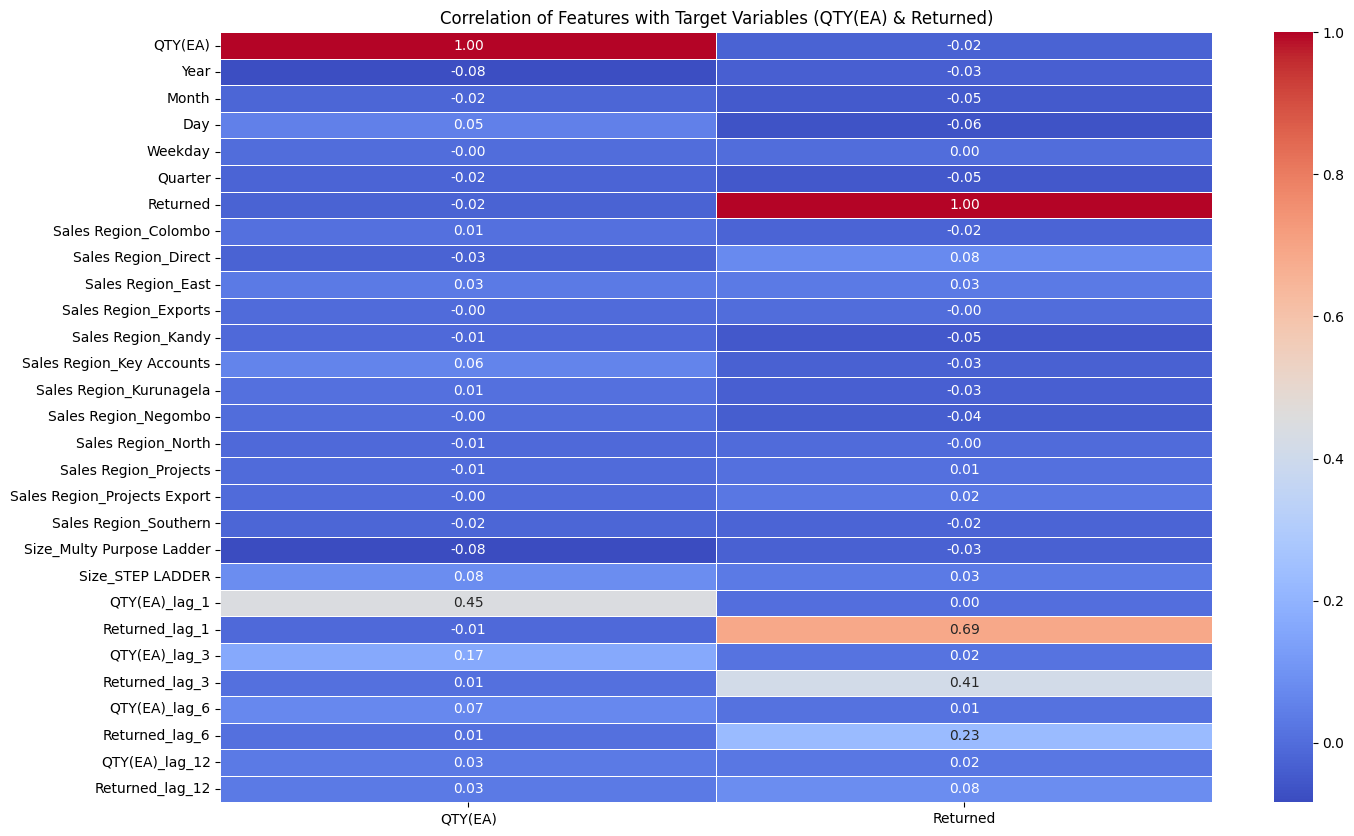

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Load the dataset
file_path = 'Ladders updated data.xlsx'
data = pd.ExcelFile(file_path)

# Load the 'Data' sheet
df = data.parse('Data')

# Display the first few rows to understand the structure
print("First 5 rows of the dataset:")
print(df.head())

# Check basic information about the dataset
print("\nDataset Information:")
df.info()

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Summary statistics for numerical columns
print("\nSummary Statistics:")
print(df.describe())

# Check unique values in categorical columns
categorical_cols = ['Sales Region', 'Material Code', 'Size', 'QTY(EA)']
for col in categorical_cols:
    print(f"\nUnique values in {col}:")
    print(df[col].unique())

# Drop unnecessary columns
df = df.drop(columns=["Net Weight", "Invoice Value", "Material Code"])

# Convert Billing Date to datetime format
df['Billing Date'] = pd.to_datetime(df['Billing Date'])

# Extract time-based features
df['Year'] = df['Billing Date'].dt.year
df['Month'] = df['Billing Date'].dt.month
df['Day'] = df['Billing Date'].dt.day
df['Weekday'] = df['Billing Date'].dt.weekday
df['Quarter'] = df['Billing Date'].dt.quarter

# Display updated dataset
print("\nDataset after adding time-based features:")
print(df.head())

# Drop the original date column
df = df.drop(columns=["Billing Date"])
print(df.head())

# Map region codes to region names
region_mapping = {
    "R1": "North", "R2": "Kandy", "R3": "Kurunagela", "R4": "Southern", "R5": "Negombo",
    "R6": "East", "R7": "Colombo", "R8": "Key Accounts", "PR": "Projects", "PR-EX": "Projects Export",
    "EX": "Exports", "DR": "Direct"
}

# Replace Sales Region codes with actual names
df["Sales Region"] = df["Sales Region"].replace(region_mapping)

# Verify changes
print(df["Sales Region"].unique())

# Create a new column for returns (1 if it's a return, else 0)
df["Returned"] = df["QTY(EA)"].apply(lambda x: 1 if x < 0 else 0)

# Convert QTY(EA) to positive values
df["QTY(EA)"] = df["QTY(EA)"].abs()

# Verify changes
print(df.head())

# Perform One-Hot Encoding for Sales Region and Size
df = pd.get_dummies(df, columns=["Sales Region", "Size"], drop_first=False)

# Verify dataset
print(df.head())

# Convert boolean columns to integer (0 and 1)
df.iloc[:, 6:] = df.iloc[:, 6:].astype(int)

# Verify conversion
print(df.dtypes)

# Create a function for filtering and prediction
def filter_and_predict(start_date, end_date, sales_region, size):
    # Convert input dates to datetime
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Filter dataset based on the given date range
    filtered_df = df[(df["Year"] >= start_date.year) &
                     (df["Year"] <= end_date.year) &
                     (df["Month"] >= start_date.month) &
                     (df["Month"] <= end_date.month)]

    # Filter by Sales Region and Size
    region_col = f"Sales Region_{sales_region}"
    size_col = "Size_STEP LADDER" if size == "STEP LADDER" else "Size_Multy Purpose Ladder"

    if region_col in filtered_df.columns and size_col in filtered_df.columns:
        filtered_df = filtered_df[(filtered_df[region_col] == 1) & (filtered_df[size_col] == 1)]

    # Aggregate total sales and total returns
    total_sales = filtered_df["QTY(EA)"].sum()
    total_returns = filtered_df["Returned"].sum()

    return {"Sales": total_sales, "Returns": total_returns}

# Example usage
result = filter_and_predict("2023-01-07", "2023-02-07", "Kandy", "STEP LADDER")
print(result)

# Get numerical features
numerical_features = df.select_dtypes(include=['int64', 'int32', 'float64']).columns

# Print numerical features
print("Numerical Features in the Dataset:")
print(numerical_features)

# Create lag features
def create_lag_features(df, lags=[1, 3, 6, 12]):
    for lag in lags:
        df[f'QTY(EA)_lag_{lag}'] = df['QTY(EA)'].shift(lag)
        df[f'Returned_lag_{lag}'] = df['Returned'].shift(lag)
    return df

# Sort by date and create lag features
df = df.sort_values(by=['Year', 'Month', 'Day'])
df = create_lag_features(df)
df = df.dropna().reset_index(drop=True)  # Drop NaNs and reset index
print(df.head())

# Check columns and data
print(df.columns.tolist())
print(df.head())

# Scale the numerical features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[numerical_features])
df[numerical_features] = scaled_features

# Compute correlation matrix
correlation_matrix = df.corr()

# Extract correlations with target variables
target_correlation = correlation_matrix[['QTY(EA)', 'Returned']]

# Plot heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(target_correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation of Features with Target Variables (QTY(EA) & Returned)")
plt.savefig('correlation_heatmap.png')
plt.show()

# Save the processed data
df.to_csv("feature_engineered_data.csv", index=False)


In [2]:

# Define Features (X) and Target Variables (y)
X = df.drop(columns=['QTY(EA)', 'Returned'])  # Exclude target variables
y_sales = df['QTY(EA)']  # Sales target variable
y_returns = df['Returned']  # Returns target variable

# Split into Training (80%) and Testing (20%) sets
X_train, X_test, y_train_sales, y_test_sales = train_test_split(X, y_sales, test_size=0.2, random_state=42)
_, _, y_train_returns, y_test_returns = train_test_split(X, y_returns, test_size=0.2, random_state=42)

print("✅ Data Splitting Completed!")

# Initialize XGBoost models
sales_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
returns_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Train models
sales_model.fit(X_train, y_train_sales)
returns_model.fit(X_train, y_train_returns)

print("✅ Initial Model Training Completed!")



✅ Data Splitting Completed!
✅ Initial Model Training Completed!


In [3]:
# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, target_name):
    """Evaluates the model and prints performance metrics"""
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    def print_metrics(y_true, y_pred, dataset):
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        print(f"📊 {target_name} - {dataset} Set:")
        print(f"✅ MAE: {mae:.4f} | ✅ RMSE: {rmse:.4f} | ✅ R² Score: {r2:.4f}")
        print("-" * 50)

    print_metrics(y_train, y_train_pred, "Train")
    print_metrics(y_test, y_test_pred, "Test")

# Evaluate initial models
evaluate_model(sales_model, X_train, X_test, y_train_sales, y_test_sales, "Sales (QTY)")
evaluate_model(returns_model, X_train, X_test, y_train_returns, y_test_returns, "Returns")




📊 Sales (QTY) - Train Set:
✅ MAE: 0.0109 | ✅ RMSE: 0.0301 | ✅ R² Score: 0.7260
--------------------------------------------------
📊 Sales (QTY) - Test Set:
✅ MAE: 0.0174 | ✅ RMSE: 0.0492 | ✅ R² Score: 0.2382
--------------------------------------------------
📊 Returns - Train Set:
✅ MAE: 0.0300 | ✅ RMSE: 0.1055 | ✅ R² Score: 0.7818
--------------------------------------------------
📊 Returns - Test Set:
✅ MAE: 0.0448 | ✅ RMSE: 0.1485 | ✅ R² Score: 0.5603
--------------------------------------------------


In [4]:
# Hyperparameter Grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1, 10],  # L1 Regularization
    'reg_lambda': [0, 0.1, 1, 10]  # L2 Regularization
}

# Train Sales Model using Hyperparameter Tuning
sales_model = XGBRegressor()
search_sales = RandomizedSearchCV(sales_model, param_distributions=param_grid,
                                  scoring='neg_mean_absolute_error', cv=5, n_iter=30, n_jobs=-1, verbose=1, random_state=42)
search_sales.fit(X_train, y_train_sales)

# Train Returns Model using Hyperparameter Tuning
returns_model = XGBRegressor()
search_returns = RandomizedSearchCV(returns_model, param_distributions=param_grid,
                                    scoring='neg_mean_absolute_error', cv=5, n_iter=30, n_jobs=-1, verbose=1, random_state=42)
search_returns.fit(X_train, y_train_returns)

# Best Hyperparameters
best_params_sales = search_sales.best_params_
best_params_returns = search_returns.best_params_

print("🔍 Best Hyperparameters for Sales Model:", best_params_sales)
print("🔍 Best Hyperparameters for Returns Model:", best_params_returns)

# Train Final Models with Best Hyperparameters
final_sales_model = XGBRegressor(**best_params_sales)
final_sales_model.fit(X_train, y_train_sales)

final_returns_model = XGBRegressor(**best_params_returns)
final_returns_model.fit(X_train, y_train_returns)

# Predictions
y_train_pred_sales = final_sales_model.predict(X_train)
y_test_pred_sales = final_sales_model.predict(X_test)

y_train_pred_returns = final_returns_model.predict(X_train)
y_test_pred_returns = final_returns_model.predict(X_test)

# Evaluate Sales Model
mae_train_sales = mean_absolute_error(y_train_sales, y_train_pred_sales)
rmse_train_sales = np.sqrt(mean_squared_error(y_train_sales, y_train_pred_sales))
r2_train_sales = r2_score(y_train_sales, y_train_pred_sales)

mae_test_sales = mean_absolute_error(y_test_sales, y_test_pred_sales)
rmse_test_sales = np.sqrt(mean_squared_error(y_test_sales, y_test_pred_sales))
r2_test_sales = r2_score(y_test_sales, y_test_pred_sales)

# Evaluate Returns Model
mae_train_returns = mean_absolute_error(y_train_returns, y_train_pred_returns)
rmse_train_returns = np.sqrt(mean_squared_error(y_train_returns, y_train_pred_returns))
r2_train_returns = r2_score(y_train_returns, y_train_pred_returns)

mae_test_returns = mean_absolute_error(y_test_returns, y_test_pred_returns)
rmse_test_returns = np.sqrt(mean_squared_error(y_test_returns, y_test_pred_returns))
r2_test_returns = r2_score(y_test_returns, y_test_pred_returns)

# Print the formatted results
print("\n📊 Sales (QTY) - Train Set:")
print(f"✅ MAE: {mae_train_sales:.4f} | ✅ RMSE: {rmse_train_sales:.4f} | ✅ R² Score: {r2_train_sales:.4f}")
print("--------------------------------------------------")
print("📊 Sales (QTY) - Test Set:")
print(f"✅ MAE: {mae_test_sales:.4f} | ✅ RMSE: {rmse_test_sales:.4f} | ✅ R² Score: {r2_test_sales:.4f}")
print("--------------------------------------------------")
print("📊 Returns - Train Set:")
print(f"✅ MAE: {mae_train_returns:.4f} | ✅ RMSE: {rmse_train_returns:.4f} | ✅ R² Score: {r2_train_returns:.4f}")
print("--------------------------------------------------")
print("📊 Returns - Test Set:")
print(f"✅ MAE: {mae_test_returns:.4f} | ✅ RMSE: {rmse_test_returns:.4f} | ✅ R² Score: {r2_test_returns:.4f}")


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
🔍 Best Hyperparameters for Sales Model: {'subsample': 0.8, 'reg_lambda': 10, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
🔍 Best Hyperparameters for Returns Model: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 1.0}

📊 Sales (QTY) - Train Set:
✅ MAE: 0.0145 | ✅ RMSE: 0.0410 | ✅ R² Score: 0.4909
--------------------------------------------------
📊 Sales (QTY) - Test Set:
✅ MAE: 0.0165 | ✅ RMSE: 0.0471 | ✅ R² Score: 0.3002
--------------------------------------------------
📊 Returns - Train Set:
✅ MAE: 0.0370 | ✅ RMSE: 0.1255 | ✅ R² Score: 0.6916
--------------------------------------------------
📊 Returns - Test Set:
✅ MAE: 0.0437 | ✅ RMSE: 0.1443 | ✅ R² Score: 0.5850


In [7]:
# Save the tuned models
joblib.dump(final_sales_model, "xgboost_sales.pkl") # Changed 'best_sales_model' to 'final_sales_model'
joblib.dump(final_returns_model, "xgboost_returns.pkl") # Changed 'best_returns_model' to 'final_returns_model'

# Save the scaler
feature_columns = X.columns
scaler = MinMaxScaler()
scaler.fit(df[feature_columns])
joblib.dump(scaler, "scaler.pkl")

print("✅ Models and Scaler Saved Successfully!")
print("Feature names used during training:", list(final_sales_model.feature_names_in_)) # Changed 'best_sales_model' to 'final_sales_model'

✅ Models and Scaler Saved Successfully!
Feature names used during training: ['Year', 'Month', 'Day', 'Weekday', 'Quarter', 'Sales Region_Colombo', 'Sales Region_Direct', 'Sales Region_East', 'Sales Region_Exports', 'Sales Region_Kandy', 'Sales Region_Key Accounts', 'Sales Region_Kurunagela', 'Sales Region_Negombo', 'Sales Region_North', 'Sales Region_Projects', 'Sales Region_Projects Export', 'Sales Region_Southern', 'Size_Multy Purpose Ladder', 'Size_STEP LADDER', 'QTY(EA)_lag_1', 'Returned_lag_1', 'QTY(EA)_lag_3', 'Returned_lag_3', 'QTY(EA)_lag_6', 'Returned_lag_6', 'QTY(EA)_lag_12', 'Returned_lag_12']


In [10]:
import joblib
import pandas as pd
import numpy as np
from datetime import datetime

# Load trained models
sales_model = joblib.load("xgboost_sales.pkl")
returns_model = joblib.load("xgboost_returns.pkl")

# Load the saved scaler
scaler = joblib.load("scaler.pkl")

# Load historical data for lag features
df = pd.read_csv("feature_engineered_data.csv")

def prepare_input(start_date, end_date, size, region, df):
    """
    Prepare input data for making predictions with the trained models.

    Args:
        start_date (str): Start date of the prediction period (e.g., "01/01/2025").
        end_date (str): End date of the prediction period (e.g., "01/02/2025").
        size (str): Size of the ladder ("Step Ladder" or "Multi Purpose Ladder").
        region (str): Sales region name (e.g., "Kandy").
        df (pd.DataFrame): Historical data DataFrame containing lag features.

    Returns:
        np.ndarray: Scaled features ready for prediction.
        pd.DataFrame: Input data before scaling for debugging.
    """
    if df.empty:
        raise ValueError("The DataFrame is empty. Please check the data source.")

    # Convert date to Year, Month, Day, Weekday, and Quarter
    start_dt = datetime.strptime(start_date, "%d/%m/%Y")

    year = start_dt.year
    month = start_dt.month
    day = start_dt.day
    weekday = start_dt.weekday()
    quarter = (month - 1) // 3 + 1

    # Ensure all feature names are strings
    feature_names = [str(name) for name in sales_model.feature_names_in_]

    # Get all region and size columns from the model features
    region_columns = [col for col in feature_names if col.startswith('Sales Region_')]
    size_columns = [col for col in feature_names if col.startswith('Size_')]

    # Initialize all region and size columns to 0
    region_dict = {col: 0 for col in region_columns}
    size_dict = {col: 0 for col in size_columns}

    # Set the correct region column to 1
    region_key = f"Sales Region_{region}"
    if region_key in region_dict:
        region_dict[region_key] = 1

    # Set the correct size column to 1
    # Handle different possible formats of size
    size_lower = size.lower()
    if "step ladder" in size_lower:
        size_col = "Size_STEP LADDER"
    elif "multi purpose" in size_lower or "multy purpose" in size_lower:
        size_col = "Size_Multy Purpose Ladder"
    else:
        size_col = next((col for col in size_columns if size.lower() in col.lower()), size_columns[0])

    if size_col in size_dict:
        size_dict[size_col] = 1

    # Retrieve Lag Values from Historical Data
    last_row = df.iloc[-1]  # Get the last available row for lags
    lag_columns = [col for col in feature_names if "_lag_" in col]
    lag_dict = {col: last_row.get(col, 0) for col in lag_columns}

    # Create a DataFrame with all the expected columns
    input_data = {
        "Year": year,
        "Month": month,
        "Day": day,
        "Weekday": weekday,
        "Quarter": quarter,
        **region_dict,
        **size_dict,
        **lag_dict
    }

    # Create DataFrame with expected column names
    input_df = pd.DataFrame([input_data])

    # Convert DataFrame column names to strings to match model expectations
    input_df.columns = input_df.columns.astype(str)

    # Create a mapping of string column names to use for reordering
    model_features = [str(name) for name in sales_model.feature_names_in_]

    # Ensure column order matches exactly what's expected by the model
    input_df = input_df[model_features]

    # Debugging: Ensure correct feature alignment
    print(f"✅ input_df columns: {list(input_df.columns)}")
    print(f"✅ Expected model features: {model_features}")

    # Scale the features using the trained scaler
    scaled_features = scaler.transform(input_df)

    return scaled_features, input_df

def predict_ladder_sales(start_date, end_date, size, region):
    """
    Predict ladder sales and returns for a given date range, size, and region.

    Args:
        start_date (str): Start date in format "DD/MM/YYYY"
        end_date (str): End date in format "DD/MM/YYYY"
        size (str): "Step Ladder" or "Multi Purpose Ladder"
        region (str): Sales region name

    Returns:
        dict: Dictionary containing predicted sales and returns as integers
    """
    # Load historical data
    historical_data = pd.read_csv("feature_engineered_data.csv")

    # Prepare input for prediction
    test_input, input_df = prepare_input(start_date, end_date, size, region, historical_data)

    # Make predictions
    raw_predicted_sales = sales_model.predict(test_input)[0]
    raw_predicted_returns = returns_model.predict(test_input)[0]

    # Convert to positive integers (we can't have negative sales or returns)
    # Use ceiling for sales to ensure we don't underestimate
    # Use round for returns as it's typically a small percentage
    predicted_sales = max(1, int(np.ceil(raw_predicted_sales * 100)))  # Scale up by 100 due to normalization
    predicted_returns = max(0, int(np.round(raw_predicted_returns * predicted_sales)))  # Returns as proportion of sales

    # Calculate return rate
    return_rate = (predicted_returns / predicted_sales * 100) if predicted_sales > 0 else 0

    # Calculate data for date range (number of days)
    start_dt = datetime.strptime(start_date, "%d/%m/%Y")
    end_dt = datetime.strptime(end_date, "%d/%m/%Y")
    days_diff = (end_dt - start_dt).days + 1  # Include both start and end days

    # Adjust predictions for multiple days if applicable
    if days_diff > 1:
        predicted_sales = predicted_sales * days_diff
        predicted_returns = predicted_returns * days_diff

    return {
        "predicted_sales": predicted_sales,
        "predicted_returns": predicted_returns,
        "return_rate": return_rate
    }

# Example usage
if __name__ == "__main__":
    # Example input data
    start_date = "01/03/2025"
    end_date = "10/05/2025"
    size = "Step Ladder"
    region = "Kandy"

    # Make prediction
    prediction = predict_ladder_sales(start_date, end_date, size, region)

    # Print results
    print("\n===== LADDER SALES PREDICTION =====")
    print(f"Date Range: {start_date} to {end_date}")
    print(f"Ladder Type: {size}")
    print(f"Region: {region}")
    print("-" * 40)
    print(f"📌 Predicted Sales: {prediction['predicted_sales']} units")
    print(f"📌 Predicted Returns: {prediction['predicted_returns']} units")
    print(f"📌 Return Rate: {prediction['return_rate']:.2f}%")
    print("=" * 40)

✅ input_df columns: ['Year', 'Month', 'Day', 'Weekday', 'Quarter', 'Sales Region_Colombo', 'Sales Region_Direct', 'Sales Region_East', 'Sales Region_Exports', 'Sales Region_Kandy', 'Sales Region_Key Accounts', 'Sales Region_Kurunagela', 'Sales Region_Negombo', 'Sales Region_North', 'Sales Region_Projects', 'Sales Region_Projects Export', 'Sales Region_Southern', 'Size_Multy Purpose Ladder', 'Size_STEP LADDER', 'QTY(EA)_lag_1', 'Returned_lag_1', 'QTY(EA)_lag_3', 'Returned_lag_3', 'QTY(EA)_lag_6', 'Returned_lag_6', 'QTY(EA)_lag_12', 'Returned_lag_12']
✅ Expected model features: ['Year', 'Month', 'Day', 'Weekday', 'Quarter', 'Sales Region_Colombo', 'Sales Region_Direct', 'Sales Region_East', 'Sales Region_Exports', 'Sales Region_Kandy', 'Sales Region_Key Accounts', 'Sales Region_Kurunagela', 'Sales Region_Negombo', 'Sales Region_North', 'Sales Region_Projects', 'Sales Region_Projects Export', 'Sales Region_Southern', 'Size_Multy Purpose Ladder', 'Size_STEP LADDER', 'QTY(EA)_lag_1', 'Retur